In [1]:
from networks.UNet import LitUNet
from lightning import Trainer
from torch.nn.functional import softmax

In [2]:
import os
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob

In [3]:
from data.dataset import OEMMiniDataset
from torch.utils.data import DataLoader

In [4]:
map_location = {'cuda:0':'cpu'}
ckpt_pth = glob('/home/ubuntu/hrl/oem_mini_experiments/.neptune/Untitled/MIN-38/checkpoints/*.ckpt')
model = LitUNet.load_from_checkpoint(checkpoint_path=ckpt_pth[0], map_location='cpu')
trainer = Trainer(accelerator='cpu',num_nodes=1)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/conda/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [5]:
from matplotlib.pyplot import figure

def pred_labels(trainer, dataloader):
    preds = trainer.predict(model, dataloaders=dataloader)
    # preds = torch.argmax(preds[0], dim=1), dim=1).permute(1,2,0).numpy()
    
    return preds[0][0]

def viz_data(image_pth):
    img = imread(image_pth)
    img_list = glob(image_pth)
    predict_loader = DataLoader(OEMMiniDataset(img_list), batch_size=1)
    preds = pred_labels(trainer=trainer, dataloader=predict_loader)
    plt.rcParams["figure.figsize"] = (12,4)
    try:
        label = imread(image_pth.replace('/images/', '/labels/'))
        pl, pc= np.unique(preds, return_counts=True)
        al, ac= np.unique(label, return_counts=True)
        f, imx = plt.subplots(1,3)
        imx[0].imshow(img)
        imx[0].set_title('RGB')
        imx[1].imshow(label)
        imx[1].set_title('GT')
        imx[2].imshow(preds)
        imx[2].set_title('Predicted')
        print(f'Pred Labels found: {pl}')
        np.set_printoptions(precision=3, suppress=True)
        print(f'Pred percentages: {pc/np.sum(pc)*100}')
        print(f'Actual Labels found: {al}')
        np.set_printoptions(precision=3, suppress=True)
        print(f'Pred percentages: {ac/np.sum(ac)*100}')
        
    except:
        pl, pc= np.unique(preds, return_counts=True)
        f, imx = plt.subplots(1,2)
        imx[0].imshow(img)
        imx[1].imshow(preds)
        print(f'Pred Labels found: {pl}')
        np.set_printoptions(precision=3, suppress=True)
        print(f'Label percentages: {pc/np.sum(pc)*100}')

    

Predicting: |          | 0/? [00:00<?, ?it/s]

Pred Labels found: [2 3 4 5 6 8]
Pred percentages: [21.632 26.342 12.793  5.699  0.029 33.505]
Actual Labels found: [2 3 4 5 6 8]
Pred percentages: [21.921 23.313 11.31   8.681  0.008 34.767]


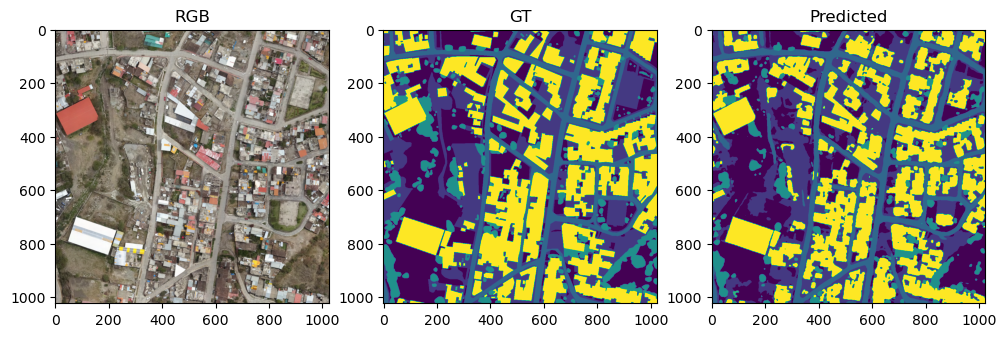

In [11]:
pred_img_path = sorted(glob('/home/ubuntu/hrl/oem_mini_experiments/data/processing/OpenEarthMap_Mini/*/images/*.tif'))[25]
viz_data(pred_img_path)